In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [1]:
import gdown
file_id = '1p4a_lfDgFBpcUe1n0YMiVrtObQUxv8t6' 
url = f'https://drive.google.com/uc?id={file_id}'

output = 'fruit_dataset.zip'  # name of the file when saved
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1p4a_lfDgFBpcUe1n0YMiVrtObQUxv8t6
From (redirected): https://drive.google.com/uc?id=1p4a_lfDgFBpcUe1n0YMiVrtObQUxv8t6&confirm=t&uuid=b1b84538-8011-42d1-b38b-8bcca089c4c6
To: d:\New_pc\FinalYearProjectData\Object_detection\code\fruit_dataset.zip
100%|██████████| 3.91G/3.91G [06:44<00:00, 9.66MB/s]


'fruit_dataset.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('fruit_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('fruit_dataset')

In [2]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Define paths
train_dir = r'D:\New_pc\FinalYearProjectData\Object_detection\archive (1)\dataset\train'
test_dir = r'D:\New_pc\FinalYearProjectData\Object_detection\archive (1)\dataset\test'

In [4]:
# Image size and batch size
img_size = (128, 128)
batch_size = 32

In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep order for evaluation
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())
print("Class Indices:", test_generator.class_indices)
print("Class Labels Order:", class_labels)

Found 13672 images belonging to 9 classes.
Found 3413 images belonging to 9 classes.
Found 3895 images belonging to 9 classes.
Class Indices: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5, 'unripe apple': 6, 'unripe banana': 7, 'unripe orange': 8}
Class Labels Order: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']


In [6]:
# ----------------- Create CNN Model with MobileNetV2 -----------------
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze initial layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_labels), activation='softmax')  # Dynamic number of classes
])

In [7]:
# ----------------- Compile Model -----------------
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# ----------------- Callbacks -----------------
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [8]:
# ----------------- Train Model -----------------
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
428/428 [==============================] - 143s 304ms/step - loss: 1.0009 - accuracy: 0.6879 - val_loss: 0.3440 - val_accuracy: 0.8731 - lr: 5.0000e-04
Epoch 2/30
428/428 [==============================] - 118s 275ms/step - loss: 0.6494 - accuracy: 0.7714 - val_loss: 0.3455 - val_accuracy: 0.8673 - lr: 5.0000e-04
Epoch 3/30
428/428 [==============================] - 113s 264ms/step - loss: 0.5358 - accuracy: 0.8076 - val_loss: 0.2963 - val_accuracy: 0.8816 - lr: 5.0000e-04
Epoch 4/30
428/428 [==============================] - 114s 265ms/step - loss: 0.4757 - accuracy: 0.8314 - val_loss: 0.3000 - val_accuracy: 0.8901 - lr: 5.0000e-04
Epoch 5/30
428/428 [==============================] - 116s 270ms/step - loss: 0.4392 - accuracy: 0.8382 - val_loss: 0.2753 - val_accuracy: 0.8960 - lr: 5.0000e-04
Epoch 6/30
428/428 [==============================] - 126s 294ms/step - loss: 0.4036 - accuracy: 0.8488 - val_loss: 0.2715 - val_accuracy: 0.9036 - lr: 5.0000e-04
Epoch 7/30
428/428 [==

In [9]:
# Save Model
model.save('image_classification.h5')

In [10]:
# ----------------- Evaluate Model -----------------
test_results = model.evaluate(test_generator)
print("\nTest Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

# Generate Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

122/122 [==============================] - 14s 111ms/step - loss: 0.1238 - accuracy: 0.9589

Test Loss: 0.12380532920360565
Test Accuracy: 0.9589216709136963
122/122 [==============================] - 11s 82ms/step



Classification Report:
               precision    recall  f1-score   support

  freshapples       0.93      1.00      0.96       395
  freshbanana       0.98      1.00      0.99       381
 freshoranges       0.99      0.99      0.99       388
 rottenapples       0.99      0.99      0.99       601
 rottenbanana       0.99      1.00      0.99       530
rottenoranges       0.99      0.98      0.99       403
 unripe apple       0.86      0.85      0.86       391
unripe banana       0.97      0.92      0.94       406
unripe orange       0.91      0.87      0.89       400

     accuracy                           0.96      3895
    macro avg       0.96      0.96      0.96      3895
 weighted avg       0.96      0.96      0.96      3895


Confusion Matrix:


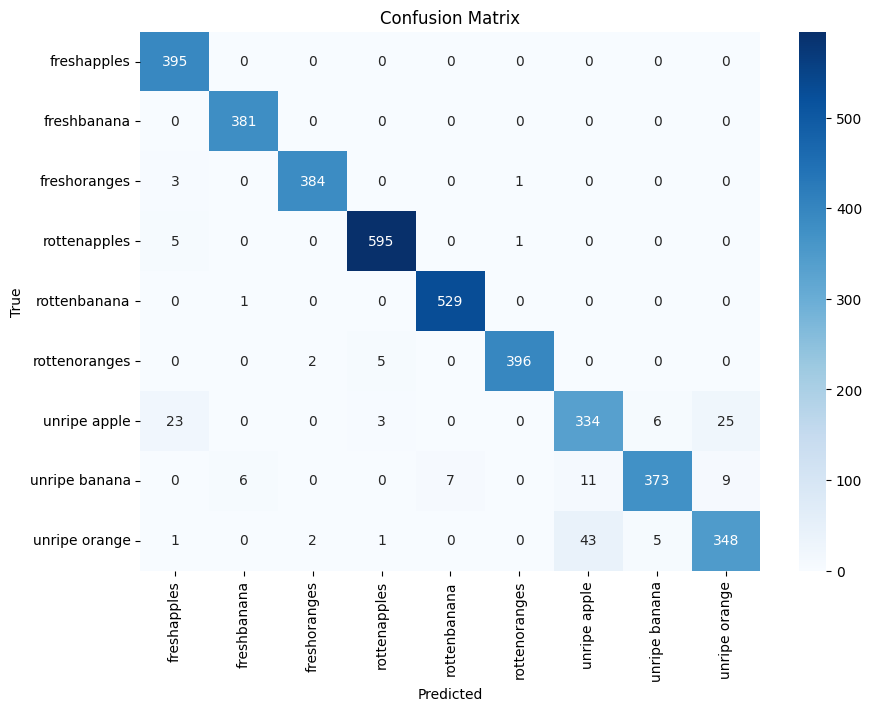

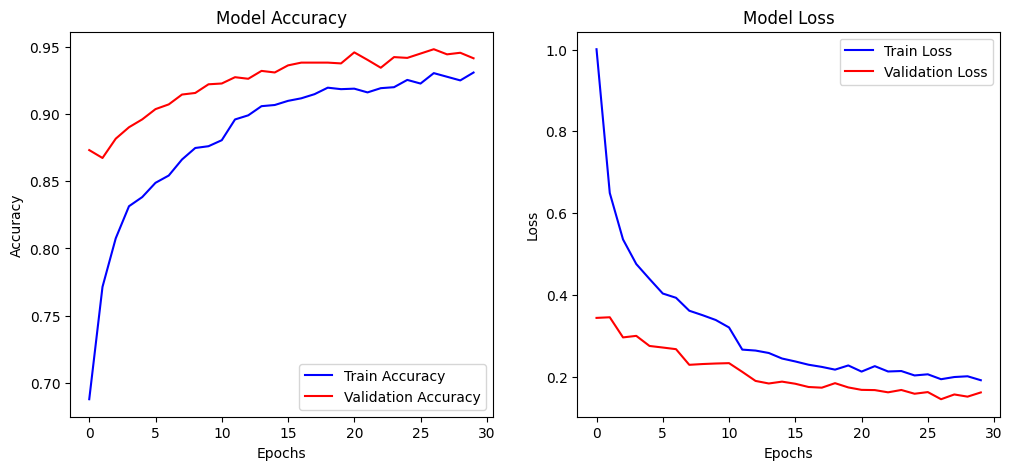

In [11]:
# ----------------- Print Classification Report & Confusion Matrix -----------------
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ----------------- Function to Plot Training History -----------------
def plot_training(history):
    plt.figure(figsize=(12,5))

    # Accuracy Plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

plot_training(history)

In [8]:
# ----------------- Load Model for Inference -----------------
model = load_model('image_classification.h5')

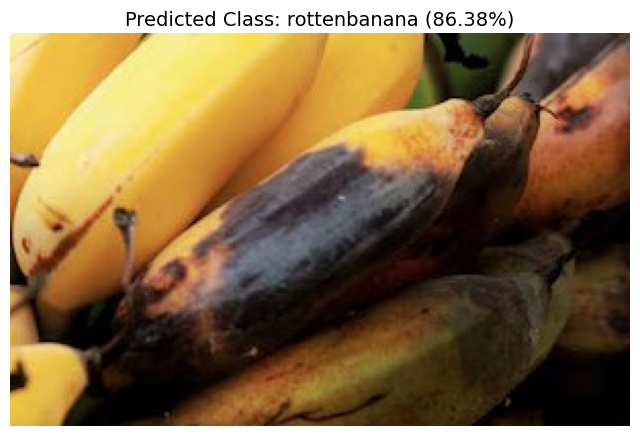

Predicted Class: rottenbanana (86.38%)


In [9]:
# ----------------- Function to Predict & Display Image -----------------
def predict_and_display_image(img_path, model, class_labels):
    img_display = Image.open(img_path)

    # Preprocess Image
    img = load_img(img_path, target_size=img_size, color_mode='rgb')
    img_array = img_to_array(img) / 255.0  # Ensure consistency with training
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array, verbose=0)
    class_index = np.argmax(prediction)
    predicted_label = class_labels[class_index]
    confidence = prediction[0][class_index] * 100

    # Display Image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label} ({confidence:.2f}%)", fontsize=14)
    plt.show()

    return predicted_label, confidence

# ----------------- Image Path for Testing -----------------
img_path = r"D:\New_pc\FinalYearProjectData\Object_detection\FinalYearSampleImages\banana-ripe-rotten-farm-with-sunlight_29084-3013 (1).jpg"
# Predict & Display Image
predicted_label, confidence = predict_and_display_image(img_path, model, class_labels)

# Print Predicted Class
print(f"Predicted Class: {predicted_label} ({confidence:.2f}%)")